 Задание на программирование
Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания. После того, как все ответы совпадут, можно будет использовать полученный блокнот для выполнения индивидуального задания.

Зададим гиперпараметры модели



In [56]:
import gym
import numpy as np
import time
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Гиперпараметры
epsilon = 0.05  # Эпсилон для эпсилон-жадной стратегии
gamma = 0.9  # Коэффициент дисконтирования
random_seed = 2  # Фиксируем сид для воспроизводимости
lr_rate = 0.9  # Скорость обучения

time_delay = 1  # Задержка при отрисовке игры

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр is_slippery=False отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию generate_random_map , для того, чтобы генерировать произвольные карты на основе random_seed .

In [57]:

# Функция генерации карты
def generate_random_map(size, p, sd):
    np.random.seed(sd)
    valid = False

    def is_valid(res):
        frontier, discovered = [(0, 0)], set()
        while frontier:
            r, c = frontier.pop()
            if (r, c) in discovered:
                continue
            discovered.add((r, c))
            for x, y in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
                r_new, c_new = r + x, c + y
                if 0 <= r_new < size and 0 <= c_new < size:
                    if res[r_new][c_new] == 'G':
                        return True
                    if res[r_new][c_new] not in '#H':
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1 - p])
        res[0][0], res[-1][-1] = 'S', 'G'
        valid = is_valid(res)

    return ["".join(row) for row in res]

# Создание среды
random_map = generate_random_map(size=6, p=0.8, sd=random_seed)
maze=random_map
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False)
print("Ваша карта")
env.reset()
env.render()

Ваша карта

SFFFFF
FFFFFF
FFFFHF
HFFFFF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса environment, то есть:

action = env.action_space.sample()

Задача 1

Дополните функцию learn(), чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения

In [58]:
#@title Вывод количества побед и номера игры, когда впервые было одержано 5 побед подряд
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
        #action = env.action_space.sample()
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    #Q-learning
    if done:
      Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
      Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.

In [59]:


from tqdm import tqdm
# Inititalization
wins_arr = [] #delete
np.random.seed(random_seed)
total_episodes = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
min_episode = 0 #delete
#Main cycle
for episode in tqdm(range(total_episodes)):
    state = env.reset()
    t = 0
    while t < max_steps:
      #delete
        if episode > 5 and wins_arr[episode-5] == 1 and wins_arr[episode-4] == 1 and wins_arr[episode-3] == 1 and wins_arr[episode-2] == 1 and wins_arr[episode-1] == 1 and min_episode ==0:
          min_episode = episode

        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True

        learn(state, state2, reward, action, done)

        state = state2

        if done and reward == 1:
          wins_arr.append(1) #record if won
          break
        if done:
          wins_arr.append(0) #record if lost
          break

#print("Таблица ценностей действий")
#print(np.round(Q,2))
#Number of wins
print('')
print("Количество побед в серии из 10 000 игр: ", np.sum(wins_arr))
#Number of the episode
print("Пять побед подряд впервые было одержано в игре ",min_episode)

100%|██████████| 10000/10000 [00:03<00:00, 3187.54it/s]


Количество побед в серии из 10 000 игр:  9824
Пять побед подряд впервые было одержано в игре  81


Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [60]:

#@title Отдельная игра после обучения
#Just 1 game to check if Q-table fits to win
from IPython.display import clear_output
import time

def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action
states=[]
t = 0
state = env.reset()

while(t<1000):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  #print(reward)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")



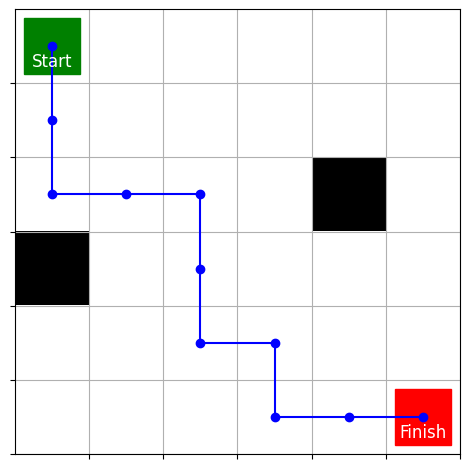

In [61]:
#@title Построение карты маршрута
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(maze)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
rw = np.append(rw, [nrows-1])
cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")


# Задача 3

Дублируйте полученный блокнот и используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что в задании требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.